<a href="https://colab.research.google.com/github/georgeliu1998/sentiment_word_embedding/blob/master/sentiment_word_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis with Word Embedding and RNN

## Setting up the Environment

In [2]:
import numpy as np
np.random.seed(8)
seed = np.random.RandomState(8)

import tensorflow as tf
tf.set_random_seed(8)

import urllib.request
import tarfile
import os
import re
import string
from time import time

import pandas as pd
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, LSTM
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding

from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer

Using TensorFlow backend.


In [0]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [7]:
!python -m spacy download en_core_web_md

    100% |████████████████████████████████| 120.9MB 61.3MB/s 
  Running setup.py install for en-core-web-md ... - \ | / - \ | / - \ done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_md -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')



In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Getting the Data

In [0]:
url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

path = './gdrive/My Drive/WorkingDir/sentiment_word_embedding'
download_folder = 'raw_data'
download_name = 'imdb.tar.gz'
path_name = os.path.join(path, download_folder, download_name)

# Download data to the specified path
urllib.request.urlretrieve(url, path_name)

#extract_path = os.path.join(path, download_folder)

with tarfile.open(path_name) as tar:
  #tar.extractall(path=extract_path)
  tar.extractall()

('./gdrive/My Drive/WorkingDir/sentiment_word_embedding/raw_data/imdb.tar.gz',
 <http.client.HTTPMessage at 0x7fa4dbb55898>)

In [0]:
def load_imdb(path):
  """
  Loads train and test data into dataframes.

  Params
  ---------------------
  path: str
    The path to the unzipped aclImdb folder.

  Returns
  ---------------------
  df_train, df_test: tuple of of pandas df
    The dataframes created from data
  """

  data = {}

  for split in ['train', 'test']:
    data[split] = []

    for label in ['pos', 'neg']:
      sentiment = 1 if label == 'pos' else 0
      file_names = os.listdir(os.path.join(path, split, label))

      for file_name in file_names:
        file_path = os.path.join(path, split, label, file_name)
        with open(file_path, "r") as f:
          review = f.read()

          data[split].append([review, sentiment])

  np.random.shuffle(data['train'])        
  df_train = pd.DataFrame(data['train'], columns=['review', 'sentiment'])

  np.random.shuffle(data['test'])
  df_test = pd.DataFrame(data['test'], columns=['review', 'sentiment'])

  return df_train, df_test


def save_df(df, path, save_name):
  file_name = save_name + '.csv'
  path_name = os.path.join(path, file_name)
  
  df.to_csv(path_name, index=False)


def load_data():
  """
  Loads all train test data
  """
  
  path = './gdrive/My Drive/WorkingDir/sentiment_word_embedding'
  
  df_train = pd.read_csv(os.path.join(path, 'df_train.csv'))
  df_test = pd.read_csv(os.path.join(path, 'df_test.csv'))
  
  #X_train = np.loadtxt(os.path.join(path, 'X_train.csv'), delimiter=",")
  #X_test = np.loadtxt(os.path.join(path, 'X_test.csv'), delimiter=",")
  #y_train = df_train['sentiment'].values
  #y_test = df_test['sentiment'].values
  
  return df_train, df_test #X_train, X_test, y_train, y_test 

In [0]:
df_train, df_test = load_imdb('./aclImdb')

save_df(df=df_train, path=path, save_name='df_train')
save_df(df=df_test, path=path, save_name='df_test')

## Data Preprocessing

In [0]:
def preprocess_text(text, lemmatizing=False):
    """
    Preprocesses text by removing all stop words and lemmatizing.
    
    Params
    --------------
    text: str
      the string to be cleaned
    
    Returns
    --------------
    text: str
      the cleaned string

    """
    text = text.lower()
    
    if lemmatizing:
      lemmatizer = WordNetLemmatizer()
      text = ' '.join([lemmatizer.lemmatize(word, pos='v') for word in text.split()])
    
    # Remove html tags
    text = re.sub(r'<.*?>', '', text)
    
    # Replace punctuation with spaces
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(translator)

    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    
    # Remove additional white spaces
    text = ' '.join(text.split())
    
    return text

In [0]:
t1 = time()

X_train = df_train['review'].apply(preprocess_text)

t2 = time()

t = (t2 - t1) / 60

print('Took {} min'.format(t))

Took 14.381852738062541 min


In [0]:
df_train['review_processed'] = X_train
df_train.head()

,review,sentiment,review_processed
0,I could never remember the name of this show. ...,1,-0.037421
1,"Going into this movie, I had heard good things...",1,-0.009028
2,The only scary thing about this movie is the t...,0,-0.050488
3,This deserves a 12 out of 10. An absolutely re...,1,-0.047448
4,"Joan Fontaine is ""A Damsel in Distress"" in thi...",1,-0.060614


In [0]:
save_df(df=df_train, path=path, save_name='df_train')

In [0]:
t1 = time()

df_test['review_processed'] = df_test['review'].apply(preprocess_text)

t2 = time()

t = (t2 - t1) / 60

save_df(df=df_test, path=path, save_name='df_test')

print('Took {} min'.format(t))

Took 13.990289672215779 min


In [0]:
df_test.head()

,review,sentiment,review_processed
0,"""Thunderbolt"" is probably Jackie Chan's worst ...",0,thunderbolt probably jackie chan worst movie s...
1,This is the worst movie that I have ever seen....,0,worst movie ever seen first thought going good...
2,(Warning: Some spoilers ahead.)<br /><br />Wha...,0,warning spoilers ahead incredibly crappy movie...
3,This film is a perfect example of how to take ...,0,film perfect example take fascinating subject ...
4,"Ok, everybody agreed on what was the best seas...",1,ok everybody agreed best season first killing ...


## Modeling with CountVectorizer and SVC

In [0]:
# Transform each text into a vector of word counts
vectorizer = CountVectorizer()

training_features = vectorizer.fit_transform(df_train['review_processed'])    
test_features = vectorizer.transform(df_test['review_processed'])

# Training
model = LinearSVC()
model.fit(training_features, df_train['sentiment'])
y_pred = model.predict(test_features)

# Evaluation
acc = accuracy_score(df_test['sentiment'], y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

Accuracy on test set: 84.14%


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Modeling with Word Embedding and Neural Networks

In [0]:
# Load the spacy model
nlp = spacy.load('en_core_web_md')

In [0]:
df_train, df_test = load_data()

In [0]:
# Get the first 1000 samples from train dataset
#X_train, y_train = X_train[:1000,], y_train[:1000]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 300), (25000,), (25000, 300), (25000,))

In [0]:
t1 = time()

X_train = np.array(list(df_train['review_processed'].apply(lambda x: nlp(x).vector.tolist())))

t2 = time()

t = (t2 - t1) / 60

path_name = os.path.join(path, 'X_train_vector.csv')

np.savetxt(path_name, X_train, delimiter=',') 

print('Took {} min'.format(t))

Took 21.16675995985667 min


In [0]:
t1 = time()

X_test = np.array(list(df_test['review_processed'].apply(lambda x: nlp(x).vector.tolist())))

t2 = time()

t = (t2 - t1) / 60

path_name = os.path.join(path, 'X_test_vector.csv')

np.savetxt(path_name, X_test, delimiter=',') 

print('Took {} min'.format(t))

Took 20.361665081977844 min


In [0]:
from keras.optimizers import RMSprop

model = Sequential()
model.add(Dense(64, input_dim=300, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

rmsprop = RMSprop(lr=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs=100,
          batch_size=128)

score = model.evaluate(X_test, y_test, batch_size=128)
print("\nAccuracy on the test set is: {}".format(score[1]))

## Modeling with Keras Embedding Layer

In [0]:
df_train, df_test = load_data()

In [0]:
def get_vocab(df):
  vocab = set()
  for i in df['review_processed'].str.split():
    vocab.update(i)
  
  print("Vocabulary size: {}".format(len(vocab)))
  return vocab

In [12]:
vocab_train = get_vocab(df=df_train) 
vocab_test = get_vocab(df=df_test) 

Vocabulary size: 76298
Vocabulary size: 75456


In [13]:
vocab = set.union(vocab_train, vocab_test)
len(vocab)

104971

In [14]:
vocab

{'populous',
 'shiiiit',
 'bacardi',
 'cartoon',
 'vorhees',
 'festered',
 'possesing',
 'beserk',
 'isolytic',
 'retreadeddrivel',
 'sieges',
 'electronica',
 'unsinkable',
 'greengass',
 'heino',
 'beamings',
 'unflyable',
 'sweatshirt',
 'churchgoers',
 'peru',
 'photographic',
 'promotions',
 'mignon',
 'dykstra',
 'fundsa',
 'chancy',
 'brutalize',
 'carltio',
 'inrus',
 'ressurrection',
 'intermittently',
 'mcintosh',
 'saldy',
 'marxist',
 'laudenbach',
 'maidment',
 'toleration',
 'viciente',
 'bitva',
 'ladgayan',
 'spokane',
 'jugalbandhi',
 'consummated',
 'preach',
 'hdi',
 'respondents',
 'radially',
 'alerta',
 'inanity',
 'minuets',
 'spellings',
 'englands',
 'hell',
 'lamo',
 'boss',
 'fleashens',
 'roll',
 'vigário',
 'route…but',
 'cavernously',
 'undemanding',
 'tuition',
 'newmail',
 'hokee',
 'overrunning',
 'ibiza',
 'harbours',
 'depravity',
 'videothek',
 'normalizing',
 'comprehensively',
 'garrett',
 'cryingtheir',
 'physiography',
 'k9k9',
 'nothingcons',
 '

In [15]:
vocab_size = 110000
X_oh_series = df_train.review_processed.apply(lambda x: one_hot(x, vocab_size))
X_oh = np.array([x for x in X_oh_series])
X_oh

array([list([52731, 42287, 82149, 97421, 28895, 39926, 108960, 84665, 82149, 80696, 102667, 663, 52731, 108960, 28895, 18153, 28895, 82149, 64714, 28748, 29560, 91245, 41468, 74302, 25802, 5871, 43065, 63845, 95877, 96851, 101815, 42162, 61795, 90143, 16076, 59648, 61550, 49358, 24512, 7729, 76141, 72053, 84001, 41927, 46432, 70830, 47699, 28748, 54776, 26264, 37240, 63626, 28895, 59238, 16076, 85749, 91320, 54661, 63845, 57109, 57216, 25887, 12950, 18180, 95880, 40823, 8479]),
       list([1471, 94660, 37751, 82108, 69027, 41772, 28682, 20450, 29920, 89319, 61167, 48707, 90870, 44912, 95558, 43312, 85068, 47922, 94451, 46823, 62942, 62785, 13738, 53542, 101787, 94660, 85880, 46522, 108732, 12063, 63623, 45831, 72575, 11173, 86089, 46522, 94451, 3469, 53935, 84326, 99589, 77592, 81751, 26718, 27679, 84802, 67951, 35418, 91201, 7070, 16336, 47699, 21846, 78700, 75127, 62252, 108732, 107418, 45900, 94660, 89319, 61167, 50725, 46669, 50725, 47699, 13433, 13695, 98960, 92160, 86089, 3972, 

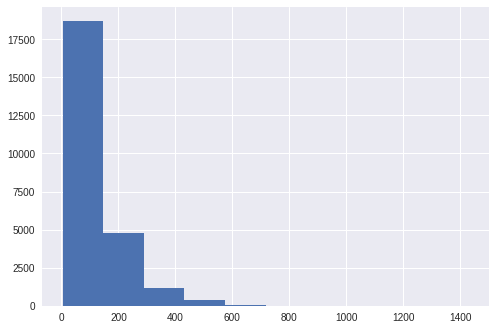

In [16]:
# Check the length distribution
X_oh_series.apply(lambda x: len(x)).hist()

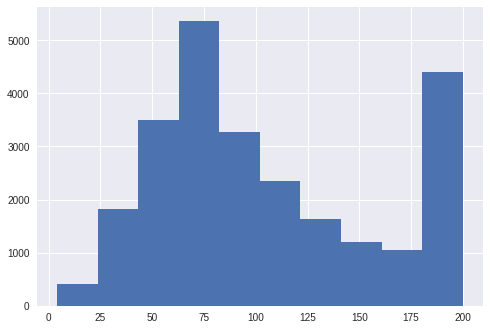

In [17]:
# Let's cut off at length 200 which covers the vast majority of lengths
X_oh_series_200 = X_oh_series.apply(lambda x: x[0:200] if len(x)>200 else x)
X_oh_series_200.apply(len).hist()

In [18]:
# Pad the docs
max_length = 200
X_train = pad_sequences(X_oh_series_200, maxlen=max_length, padding='post')
X_train

array([[ 52731,  42287,  82149, ...,      0,      0,      0],
       [  1471,  94660,  37751, ...,      0,      0,      0],
       [ 75886,  59338,  94660, ...,      0,      0,      0],
       ...,
       [ 57342,  80261, 107809, ...,      0,      0,      0],
       [  3737,  14482,  24593, ...,      0,      0,      0],
       [ 42622,  16713,  93076, ...,      0,      0,      0]], dtype=int32)

In [40]:
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 200, 8)            880000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200, 8)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 1601      
Total params: 881,601
Trainable params: 881,601
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
y_train = df_train['sentiment']

# fit the model
model.fit(X_train, y_train, epochs=10)
# evaluate the model
#loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
#print('Accuracy: %f' % (accuracy*100))

Epoch 1/10
25000/25000 [==============================] - 5s 197us/step - loss: 0.6356 - acc: 0.6444
Epoch 2/10
25000/25000 [==============================] - 5s 183us/step - loss: 0.3757 - acc: 0.8481
Epoch 3/10
25000/25000 [==============================] - 5s 181us/step - loss: 0.2757 - acc: 0.8937
Epoch 4/10
25000/25000 [==============================] - 5s 183us/step - loss: 0.2272 - acc: 0.9142
Epoch 5/10
25000/25000 [==============================] - 5s 181us/step - loss: 0.1953 - acc: 0.9261
Epoch 6/10
25000/25000 [==============================] - 5s 180us/step - loss: 0.1748 - acc: 0.9360
Epoch 7/10
25000/25000 [==============================] - 5s 181us/step - loss: 0.1556 - acc: 0.9418
Epoch 8/10
25000/25000 [==============================] - 5s 182us/step - loss: 0.1428 - acc: 0.9473
Epoch 9/10
25000/25000 [==============================] - 5s 183us/step - loss: 0.1311 - acc: 0.9510
Epoch 10/10
25000/25000 [==============================] - 5s 189us/step - loss: 0.1223 - a

In [0]:
def vectorize(df):
  vocab_size = 110000
  X_oh_series = df['review_processed'].apply(lambda x: one_hot(x, vocab_size))
  X_oh = np.array([x for x in X_oh_series])
  X_oh_series_200 = X_oh_series.apply(lambda x: x[0:200] if len(x)>200 else x)
  
  max_length = 200
  X = pad_sequences(X_oh_series_200, maxlen=max_length, padding='post')
  
  y = df['sentiment']
  
  return X, y 

In [0]:
X_test, y_test = vectorize(df_test)

In [42]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: {:.2%}'.format(accuracy))

Accuracy: 86.01%


In [0]:
X_train.shape, y_train.shape

((25000, 200), (25000,))

In [0]:
X_train

array([[66909,  2415, 15472, ...,     0,     0,     0],
       [67103, 55502, 16379, ...,     0,     0,     0],
       [26558, 14057, 55502, ...,     0,     0,     0],
       ...,
       [12722, 61657, 92995, ...,     0,     0,     0],
       [68426, 18006, 77342, ...,     0,     0,     0],
       [81220, 20894, 59985, ...,     0,     0,     0]], dtype=int32)

In [0]:
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())

## Modeling with Word Embedding and RNN

In [0]:
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop', 
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=128, epochs=10)

Epoch 1/10
25000/25000 [==============================] - 85s 3ms/step - loss: 0.6932 - acc: 0.5066
Epoch 2/10
25000/25000 [==============================] - 83s 3ms/step - loss: 0.7164 - acc: 0.5154
Epoch 3/10
25000/25000 [==============================] - 84s 3ms/step - loss: 0.6513 - acc: 0.6258
Epoch 4/10
25000/25000 [==============================] - 83s 3ms/step - loss: 0.6150 - acc: 0.6916
Epoch 5/10
25000/25000 [==============================] - 84s 3ms/step - loss: 0.6086 - acc: 0.6705
Epoch 6/10
25000/25000 [==============================] - 83s 3ms/step - loss: 0.5562 - acc: 0.7447
Epoch 7/10
25000/25000 [==============================] - 84s 3ms/step - loss: 0.5298 - acc: 0.7762
Epoch 8/10
25000/25000 [==============================] - 85s 3ms/step - loss: 0.5548 - acc: 0.7348
Epoch 9/10
25000/25000 [==============================] - 84s 3ms/step - loss: 0.4975 - acc: 0.8009
Epoch 10/10
25000/25000 [==============================] - 256s 10ms/step


In [0]:
score = model.evaluate(X_test, y_test)
score

25000/25000 [==============================] - 128s 5ms/step


[0.527516114616394, 0.80384]

In [0]:
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(LSTM(150))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop', 
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=128, epochs=10)

Epoch 1/10
25000/25000 [==============================] - 86s 3ms/step - loss: 0.6933 - acc: 0.5042
Epoch 2/10
25000/25000 [==============================] - 84s 3ms/step - loss: 0.7068 - acc: 0.5231
Epoch 3/10
25000/25000 [==============================] - 85s 3ms/step - loss: 0.6950 - acc: 0.5305
Epoch 4/10
25000/25000 [==============================] - 85s 3ms/step - loss: 0.6632 - acc: 0.6054
Epoch 5/10
25000/25000 [==============================] - 85s 3ms/step - loss: 0.6488 - acc: 0.6392
Epoch 6/10
25000/25000 [==============================] - 84s 3ms/step - loss: 0.6493 - acc: 0.6547
Epoch 7/10
25000/25000 [==============================] - 86s 3ms/step - loss: 0.6066 - acc: 0.6942
Epoch 8/10
25000/25000 [==============================] - 85s 3ms/step - loss: 0.5720 - acc: 0.7247
Epoch 9/10
25000/25000 [==============================] - 84s 3ms/step - loss: 0.5199 - acc: 0.7790
Epoch 10/10
25000/25000 [==============================] - 84s 3ms/step - loss: 0.5352 - acc: 0.7742

## To-Do's
 
- preprocess using spaCy
- lemmatize based on pos: https://stackoverflow.com/questions/41824782/lemmatize-string-according-to-pos-nlp
- 'desk\x97symbol', '\x91alonzo', '137', '230lbs', 'yes\x97it', '1988\x961992', 'yurets777', '94th', '20perr', '\x84new', 

In [0]:
def cosine_similarity(v1, v2):
  return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# Log
- original linearSVC: 84.14%
- Initial NN: 85.05%
- SVC with preprocess: 84.14%
- NN with preprocess and new embed: 85.53%
- Keras embedding and dropout: 86.01%


took 37.5 min to convert to embedding before preprocessing, 20 min after preprocessing.

In [0]:
from random import randint
from numpy import array
from numpy import argmax
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# generate a sequence of random numbers in [0, n_features)
def generate_sequence(length, n_features):
	return [randint(0, n_features-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_features):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_features)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

# generate one example for an lstm
def generate_example(length, n_features, out_index):
	# generate sequence
	sequence = generate_sequence(length, n_features)
	# one hot encode
	encoded = one_hot_encode(sequence, n_features)
	# reshape sequence to be 3D
	X = encoded.reshape((1, length, n_features))
	# select output
	y = encoded[out_index].reshape(1, n_features)
	return X, y

# define model
length = 5
n_features = 10
out_index = 2
model = Sequential()
model.add(LSTM(25, input_shape=(length, n_features)))
model.add(Dense(n_features, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

# fit model
for i in range(10000):
	X, y = generate_example(length, n_features, out_index)
	model.fit(X, y, epochs=1, verbose=2)

# evaluate model
correct = 0
for i in range(100):
	X, y = generate_example(length, n_features, out_index)
	yhat = model.predict(X)
	if one_hot_decode(yhat) == one_hot_decode(y):
		correct += 1
print('Accuracy: %f' % ((correct/100)*100.0))

# prediction on new data
X, y = generate_example(length, n_features, out_index)
yhat = model.predict(X)
print('Sequence:  %s' % [one_hot_decode(x) for x in X])
print('Expected:  %s' % one_hot_decode(y))
print('Predicted: %s' % one_hot_decode(yhat))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25)                3600      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                260       
Total params: 3,860
Trainable params: 3,860
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1
 - 11s - loss: 2.2918 - acc: 0.0000e+00
Epoch 1/1
 - 0s - loss: 2.2136 - acc: 1.0000
Epoch 1/1
 - 0s - loss: 2.3029 - acc: 0.0000e+00
Epoch 1/1
 - 0s - loss: 2.1838 - acc: 0.0000e+00
Epoch 1/1
 - 0s - loss: 2.2849 - acc: 0.0000e+00
Epoch 1/1
 - 0s - loss: 2.3127 - acc: 0.0000e+00
Epoch 1/1
 - 0s - loss: 2.2889 - acc: 0.0000e+00
Epoch 1/1
 - 0s - loss: 2.3442 - acc: 0.0000e+00
Epoch 1/1
 - 0s - loss: 2.3775 - acc: 0.0000e+00
Epoch 1/1
 - 0s - loss: 2.3271 - acc: 0.0000e+00
Epoch 1/1
 - 0s - loss: 2.2251 - acc: 0.0000

In [0]:
encoded.shape

(25, 100)

In [0]:
a = np.random.randint(10, size=5)
a

array([9, 2, 6, 9, 5])

In [0]:
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1

In [0]:
b

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [0]:
def create_array():
  a = np.random.randint(10, size=5)
  b = np.zeros((a.size, 10))
  b[np.arange(a.size),a] = 1
  return b  

In [0]:
X = np.array([create_array() for _ in range(10000)])

In [0]:
y = X[:,1,:]

In [0]:
print(X.shape, y.shape)

(10000, 5, 10) (10000, 10)


In [0]:
from random import randint
from numpy import array
from numpy import argmax
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

model = Sequential()
model.add(LSTM(25, input_shape=(5, 10)))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X, y, epochs=128)